In [5]:
import pandas as pd
import random
import numpy as np

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules
from sklearn import svm as svm

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

from sklearn.decomposition import PCA 


# Misc
import warnings
warnings.filterwarnings("ignore")
random.seed(1137)

## Austin Dataset - Default

In [232]:
austin = pd.read_csv('data/processed/austin_dv.csv')

austin['age_days'].fillna(austin['age_days'].median(), inplace=True)

In [234]:
# Split the data into a training and test dataset partitioning 75% of the data into the training data, and
# holding out 25% of the data as a test set. Set a seed to replicate your split.


y = austin[['euthanasia']]
X = austin.drop(columns=['euthanasia'])

train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25, random_state=1137)

## RF Model Implementation

In [235]:
# Used throughout each model, doesn't need to be reset each time

fold_generator = KFold(n_splits=10, shuffle=True, random_state=1137)

pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])


search_space = [

        # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[5,10,15,20],
    'model__n_estimators':[500,1000],
    'model__random_state':[1137]},
]

## Model Fitting & Evaluation - Default

In [236]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

In [237]:
search.fit(train_X,train_y.euthanasia)

GridSearchCV(cv=KFold(n_splits=10, random_state=1137, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [RandomForestClassifier(max_depth=20,
                                                           n_estimators=1000,
                                                           random_state=1137)],
                          'model__max_depth': [5, 10, 15, 20],
                          'model__n_estimators': [500, 1000],
                          'model__random_state': [1137]}],
             scoring='roc_auc')

In [238]:
search.best_score_

0.8075770598900185

In [239]:
search.best_params_

{'model': RandomForestClassifier(max_depth=20, n_estimators=1000, random_state=1137),
 'model__max_depth': 20,
 'model__n_estimators': 1000,
 'model__random_state': 1137}

In [240]:
rf_mod = search.best_estimator_

In [241]:
m.roc_auc_score(train_y,rf_mod.predict_proba(train_X)[:,1])

0.9318365077778359

In [242]:
m.accuracy_score(train_y,rf_mod.predict(train_X))

0.9823213670162998

### Compare Model Mean Test Scores - Default

In [243]:
# Mean Test Score Comparison Table Creation

scores = search.cv_results_.get('mean_test_score')
errors = search.cv_results_.get('std_test_score')

search.cv_results_.get('params')
models = [
    'RandomForest, maxdepth:5, trees:500',
    'RandomForest, maxdepth:5, trees:1000',
    'RandomForest, maxdepth:10, trees:500',
    'RandomForest, maxdepth:10, trees:1000',
        'RandomForest, maxdepth:15, trees:500',
    'RandomForest, maxdepth:15, trees:1000',
        'RandomForest, maxdepth:20, trees:500',
    'RandomForest, maxdepth:20, trees:1000',
]

d = {'model':models, 'mean_test_score':scores, 'mean_st_err':errors}
table = pd.DataFrame(data=d)

table['low'] = table['mean_test_score'] - 2*table['mean_st_err']
table['high'] = table['mean_test_score'] + 2*table['mean_st_err']
table['max'] = (table['mean_test_score'] == table['mean_test_score'].max())

#table.to_csv('model_test_score_table_noPCA.csv', index=False)
table

,model,mean_test_score,mean_st_err,low,high,max
0,"RandomForest, maxdepth:5, trees:500",0.782381,0.022098,0.738185,0.826577,False
1,"RandomForest, maxdepth:5, trees:1000",0.782567,0.022049,0.738468,0.826665,False
2,"RandomForest, maxdepth:10, trees:500",0.795118,0.020569,0.753981,0.836256,False
3,"RandomForest, maxdepth:10, trees:1000",0.795709,0.020290,0.755128,0.836289,False
4,"RandomForest, maxdepth:15, trees:500",0.804695,0.020804,0.763088,0.846302,False
5,"RandomForest, maxdepth:15, trees:1000",0.804810,0.020180,0.764450,0.845170,False
6,"RandomForest, maxdepth:20, trees:500",0.806694,0.020423,0.765848,0.847540,False
7,"RandomForest, maxdepth:20, trees:1000",0.807577,0.020575,0.766427,0.848727,True


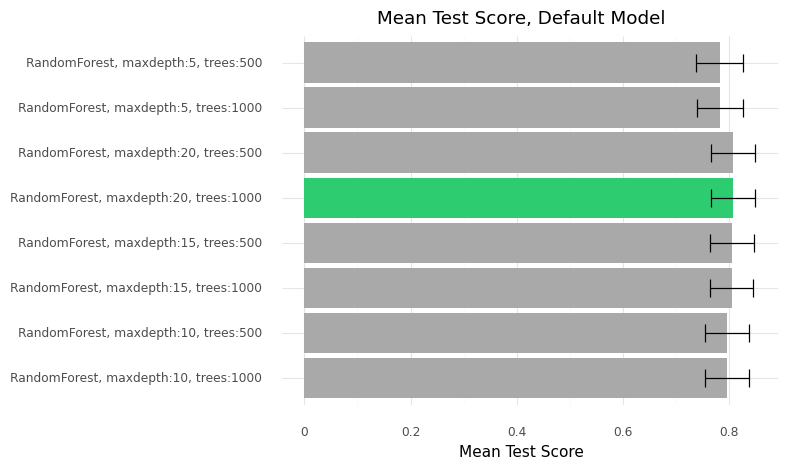

<ggplot: (8774203960748)>

In [244]:
(
ggplot(table, aes(x='model', y='mean_test_score',
                  fill='max')) + 
    geom_col() + 
    geom_errorbar(aes(ymin="low",ymax="high"),width=.4) + 
    scale_fill_manual(values=('darkgray','#2ecc71'), guide=None) + 
    coord_flip() + 
    labs(x='', y='Mean Test Score', title='Mean Test Score, Default Model') + 
    theme_minimal()
)

### Plot & Evaluated Predicted Probabilities - Default

In [162]:
preds = rf_mod.predict_proba(train_X)[:,1]

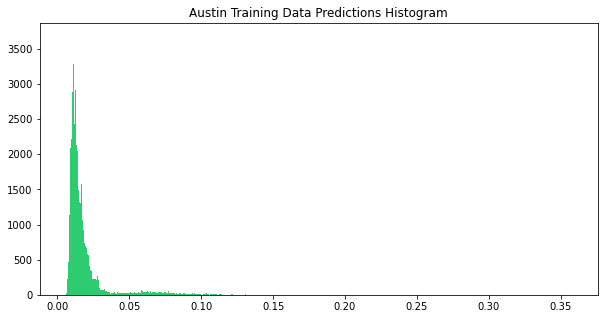

In [211]:
plt.hist(preds, bins='auto', color="#2ecc71")
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Austin Training Data Predictions Histogram")
plt.show()


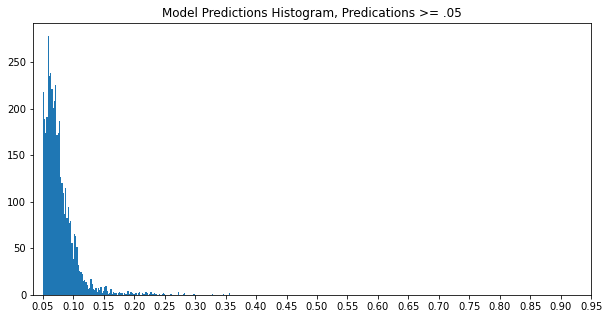

In [164]:

plt.hist(preds[preds>=.05], bins=150)
plt.rcParams["figure.figsize"] = (10, 5)
plt.title("Austin Training Data Predictions Histogram, Predications >= .05")
plt.xticks(np.arange(.05, 1, .05))
plt.show()


In [165]:
preds_bin = preds.copy()

In [166]:
preds_bin = np.where(preds_bin >= .05, 1, preds_bin)
preds_bin = np.where(preds_bin < .05, 0, preds_bin)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     79729
           1       0.14      0.42      0.21      1499

    accuracy                           0.94     81228
   macro avg       0.57      0.69      0.59     81228
weighted avg       0.97      0.94      0.96     81228



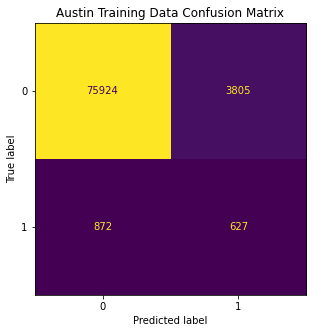

In [229]:
print(m.classification_report(train_y, preds_bin))

m.ConfusionMatrixDisplay.from_predictions(train_y, preds_bin, colorbar=False)
plt.rcParams["figure.figsize"] = (5, 5)
plt.title('Austin Training Data Confusion Matrix')
plt.show()

### Variable Importance - Default

In [75]:
## Feature Importance

vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=3)

# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat



# store
#vi_dat.to_csv("vi_dat_20_800.csv", index=False)


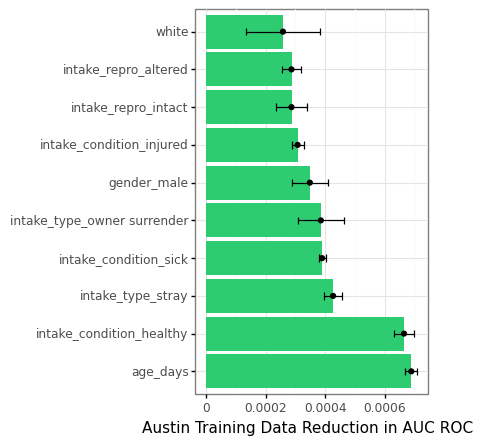

<ggplot: (8774204930844)>

In [209]:
# Plot the most important variables
(
    ggplot(vi_dat[0:10],
          aes(x="variable",y="vi")) +
    geom_col(fill="#2ecc71") +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat[0:10].variable.tolist()) +
    coord_flip() +
    labs(y="Austin Training Data Reduction in AUC ROC",x="") + 
    theme(figure_size=(3,5))
         )

## Austin Dataset - PCA

In [61]:
# Split the data into a training and test dataset partitioning 75% of the data into the training data, and
# holding out 25% of the data as a test set. Set a seed to replicate your split.


yp = austin[['euthanasia']]
Xp = austin.drop(columns=['euthanasia'])

pca = PCA(n_components=20)
pca = pca.fit(Xp)
Xp = pca.transform(Xp)

train_Xp, test_Xp, train_yp, test_yp = train_test_split(Xp,yp,test_size = .25,random_state=1137)

## Model Fitting & Evaluation - PCA

In [62]:
search_pca = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

In [63]:
search_pca.fit(train_Xp,train_yp.euthanasia)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [RandomForestClassifier(max_depth=10,
                                                           n_estimators=1000,
                                                           random_state=1137)],
                          'model__max_depth': [5, 10, 15, 20],
                          'model__n_estimators': [500, 1000],
                          'model__random_state': [1137]}],
             scoring='roc_auc')

In [64]:
search_pca.best_score_

0.7980746884749922

In [65]:
search_pca.best_params_

{'model': RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=1137),
 'model__max_depth': 10,
 'model__n_estimators': 1000,
 'model__random_state': 1137}

In [66]:
rf_mod_pca = search_pca.best_estimator_

In [67]:
m.roc_auc_score(train_yp,rf_mod_pca.predict_proba(train_Xp)[:,1])

0.9249943924872056

In [68]:
m.accuracy_score(train_yp,rf_mod_pca.predict(train_Xp))

0.9818781700891318

### Compare Model Mean Test Scores - PCA

In [69]:
# Mean Test Score Comparison Table Creation

scores_pca = search_pca.cv_results_.get('mean_test_score')
errors_pca = search_pca.cv_results_.get('std_test_score')

search_pca.cv_results_.get('params')
models_pca = [
    'RandomForest, maxdepth:5, trees:500',
    'RandomForest, maxdepth:5, trees:1000',
    'RandomForest, maxdepth:10, trees:500',
    'RandomForest, maxdepth:10, trees:1000',
    'RandomForest, maxdepth:15, trees:500',
    'RandomForest, maxdepth:15, trees:1000',
    'RandomForest, maxdepth:20, trees:500',
    'RandomForest, maxdepth:20, trees:1000',
]

dp = {'model':models_pca, 'mean_test_score':scores_pca, 'mean_st_err':errors_pca}
table_pca = pd.DataFrame(data=dp)

table_pca['low'] = table_pca['mean_test_score'] - 2*table_pca['mean_st_err']
table_pca['high'] = table_pca['mean_test_score'] + 2*table_pca['mean_st_err']
table_pca['max'] = (table_pca['mean_test_score'] == table_pca['mean_test_score'].max())

#table_pca.to_csv('model_test_score_table_PCA.csv', index=False)
table_pca

,model,mean_test_score,mean_st_err,low,high,max
0,"RandomForest, maxdepth:5, trees:500",0.777021,0.021510,0.734002,0.820041,False
1,"RandomForest, maxdepth:5, trees:1000",0.777660,0.020955,0.735750,0.819569,False
2,"RandomForest, maxdepth:10, trees:500",0.797464,0.019273,0.758918,0.836010,False
3,"RandomForest, maxdepth:10, trees:1000",0.798075,0.019084,0.759906,0.836243,True
4,"RandomForest, maxdepth:15, trees:500",0.797286,0.018629,0.760028,0.834545,False
5,"RandomForest, maxdepth:15, trees:1000",0.797946,0.018334,0.761278,0.834613,False
6,"RandomForest, maxdepth:20, trees:500",0.787404,0.016550,0.754304,0.820504,False
7,"RandomForest, maxdepth:20, trees:1000",0.788658,0.017040,0.754577,0.822738,False


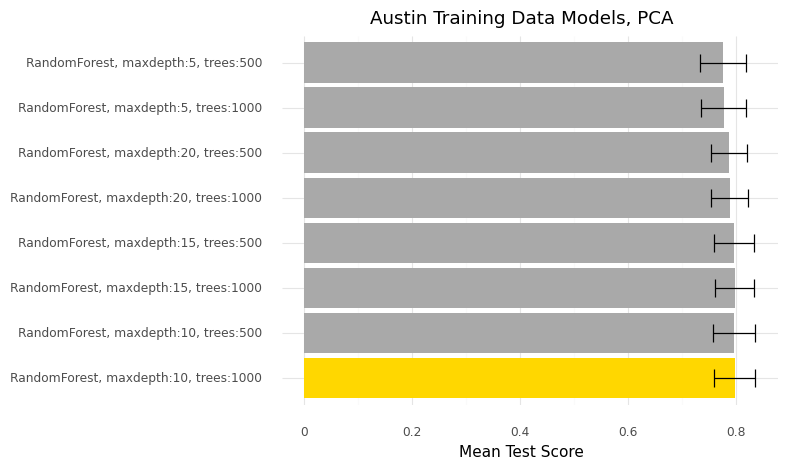

<ggplot: (8774293723507)>

In [192]:
(
ggplot(table_pca, aes(x='model', y='mean_test_score',
                  fill='max')) + 
    geom_col() + 
    geom_errorbar(aes(ymin="low",ymax="high"),width=.4) + 
    scale_fill_manual(values=('darkgray','gold'), guide=None) + 
    coord_flip() + 
    labs(x='', y='Mean Test Score', title="Austin Training Data Models, PCA") + 
    theme_minimal()
)

### Plot & Evaluated Predicted Probabilities - PCA

In [71]:
preds_pca = rf_mod_pca.predict_proba(train_Xp)[:,1]
preds_pca_bin = preds_pca.copy()

In [72]:
preds_pca_bin = np.where(preds_pca_bin >= .05, 1, preds_pca_bin)
preds_pca_bin = np.where(preds_pca_bin < .05, 0, preds_pca_bin)

In [73]:
print(m.classification_report(train_yp, preds_pca_bin))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     79729
           1       0.21      0.63      0.31      1499

    accuracy                           0.95     81228
   macro avg       0.60      0.79      0.64     81228
weighted avg       0.98      0.95      0.96     81228



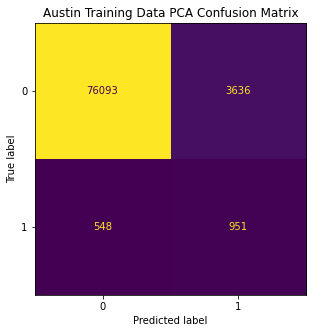

In [197]:
m.ConfusionMatrixDisplay.from_predictions(train_yp, preds_pca_bin, colorbar=False)
plt.rcParams["figure.figsize"] = (5, 5)
plt.title('Austin Training Data PCA Confusion Matrix')
plt.show()

## Austin Dataset - Reduced

In [91]:
# Split the data into a training and test dataset partitioning 75% of the data into the training data, and
# holding out 25% of the data as a test set. Set a seed to replicate your split.


yr = austin[['euthanasia']]
Xr = austin.drop(columns=['euthanasia'])

Xr.drop([
'schnauzer giant', 'samoyed', 'schipperke', 'scottish terrier', 'scottish deerhound',
'russell terrier', 'pembroke welsh corgi', 'pharaoh hound', 'shetland sheepdog', 'shiba inu',
'saluki', 'pomeranian', 'polish lowland', 'picardy sheepdog', 'shih tzu', 'parson russell terrier',
'queensland heeler', 'puli', 'pekingese', 'presa canario', 'portuguese water dog', 'pekapoo',
'patterdale terrier', 'podengo pequeno', 'toy poodle', 'petit basset griffon vendeen', 'weimaraner',
'siberian husky', 'wirehaired vizsla', 'vizsla', 'otterhound', 'welsh springer spaniel', 'west highland',
'whippet', 'wire hair fox terrier', 'wirehaired pointing griffon', 'misc', 'silky terrier',
'afghan hound', 'intake_condition_pregnant/nursing', 'intake_condition_unhealthy', 'intake_type_confiscated',
'intake_type_medical', 'intake_type_other', 'intake_type_return', 'treeing cur',
'tree walker hound', 'toy fox terrier', 'tibetan terrier', 'smooth fox terrier',
'soft coated wheaten terrier', 'spanish mastiff', 'spanish water dog', 'spinone italiano',
'st bernard rough coat', 'st bernard smooth coat', 'staffordshire', 'standard schnauzer', 'sussex spaniel',
'swedish vallhund', 'swiss hound', 'tennesee treeing brindle hound', 'tibetan mastiff','tibetan spaniel',
'papillon', 'airedale terrier', 'old english sheepdog', 'chinese crested', 'boykin spaniel',
'briard', 'brittany', 'brussels griffon', 'bull terrier miniature', 'canaan dog', 'cane corso',
'cardigan welsh corgi', 'carolina dog', 'cavalier king charles spaniel', 'chesapeake bay retriever', 'clumber spaniel',
'boston terrier', 'collie rough', 'collie smooth', 'coton de tulear', 'dalmatian',
'dandie dinmont', 'doberman pinscher', 'dogo argentino', 'dutch shepherd', 'english coonhound',
'english foxhound', 'english pointer', 'bouvier des flandres', 'borzoi', 'old english bulldog',
'beauceron', 'akita', 'alaskan husky', 'alaskan klee kai','alaskan malamute', 'australian kelpie',
'american bulldog', 'american staffordshire terrier', 'anatolian shepherd', 'australian terrier',
'basenji', 'bearded collie', 'bedlington terrier', 'boerboel', 'belgian laekenois', 'belgian malinois',
'belgian sheepdog', 'belgian tervuren', 'bernese hound', 'bernese mountain dog', 'bichon frise',
'black/tan hound', 'bloodhound', 'blue lacy', 'bluetick coonhound', 'english setter',
'english shepherd', 'english springer spaniel', 'akbash', 'karelian bear dog', 'keeshond',
'kerry blue terrier', 'korean jindo', 'kuvasz', 'lakeland terrier', 'landseer', 'leonberger',
'lhasa apso', 'lowchen', 'affenpinscher', 'mexican hairless', 'english toy spaniel', 'minature pinscher',
'minature poodle', 'minature schnauzer', 'munsterlander', 'neapolitan mastiff', 'newfoundland',
'norfolk terrier', 'norwegian buhund', 'norwegian elkhound', 'norwich terrier', 'nova scotia duck tolling retriever',
'kangal', 'jindo', 'japanese chin', 'italian greyhound', 'entlebucher', 'feist', 'field spaniel',
'fila brasileiro', 'finnish spitz', 'flat coat retriever', 'fox terrier', 'french bulldog',
'german pinscher', 'german shorthair pointer', 'german wirehair pointer', 'glen of imaal', 'gordon setter',
'great swiss mountain', 'greyhound', 'harrier', 'havanese', 'hovawart', 'ibizan hound',
'irish setter', 'irish terrier', 'irish wolfhound', 'manchester terrier', 'standard poodle'],
    inplace=True, axis=1)

train_Xr, test_Xr, train_yr, test_yr = train_test_split(Xr,yr,test_size = .25,random_state=1137)

## Model Fitting & Evaluation - Reduced

In [92]:
search_r = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

In [93]:
search_r.fit(train_Xr,train_yr.euthanasia)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [RandomForestClassifier(max_depth=15,
                                                           n_estimators=1000,
                                                           random_state=1137)],
                          'model__max_depth': [5, 10, 15, 20],
                          'model__n_estimators': [500, 1000],
                          'model__random_state': [1137]}],
             scoring='roc_auc')

In [94]:
search_r.best_score_

0.8059816572257482

In [95]:
search_r.best_params_

{'model': RandomForestClassifier(max_depth=15, n_estimators=1000, random_state=1137),
 'model__max_depth': 15,
 'model__n_estimators': 1000,
 'model__random_state': 1137}

In [96]:
rf_mod_r = search_r.best_estimator_

In [97]:
m.roc_auc_score(train_yr,rf_mod_r.predict_proba(train_Xr)[:,1])

0.9110593623558241

In [98]:
m.accuracy_score(train_yr,rf_mod_r.predict(train_Xr))

0.9822598118875264

### Compare Model Mean Test Scores - Reduced

In [99]:
# Mean Test Score Comparison Table Creation

scores_r = search_r.cv_results_.get('mean_test_score')
errors_r = search_r.cv_results_.get('std_test_score')

search_r.cv_results_.get('params')
models_r = [
    'RandomForest, maxdepth:5, trees:500',
    'RandomForest, maxdepth:5, trees:1000',
    'RandomForest, maxdepth:10, trees:500',
    'RandomForest, maxdepth:10, trees:1000',
        'RandomForest, maxdepth:15, trees:500',
    'RandomForest, maxdepth:15, trees:1000',
        'RandomForest, maxdepth:20, trees:500',
    'RandomForest, maxdepth:20, trees:1000',

]

dr = {'model':models_r, 'mean_test_score':scores_r, 'mean_st_err':errors_r}
table_r = pd.DataFrame(data=dr)

table_r['low'] = table_r['mean_test_score'] - 2*table_r['mean_st_err']
table_r['high'] = table_r['mean_test_score'] + 2*table_r['mean_st_err']
table_r['max'] = (table_r['mean_test_score'] == table_r['mean_test_score'].max())

#table_r.to_csv('model_test_score_table_r.csv', index=False)
table_r

,model,mean_test_score,mean_st_err,low,high,max
0,"RandomForest, maxdepth:5, trees:500",0.781793,0.012666,0.756461,0.807125,False
1,"RandomForest, maxdepth:5, trees:1000",0.781640,0.013037,0.755566,0.807714,False
2,"RandomForest, maxdepth:10, trees:500",0.797646,0.013465,0.770715,0.824576,False
3,"RandomForest, maxdepth:10, trees:1000",0.798095,0.013296,0.771504,0.824687,False
4,"RandomForest, maxdepth:15, trees:500",0.805886,0.016444,0.772997,0.838774,False
5,"RandomForest, maxdepth:15, trees:1000",0.805982,0.015711,0.774559,0.837404,True
6,"RandomForest, maxdepth:20, trees:500",0.803925,0.017063,0.769798,0.838052,False
7,"RandomForest, maxdepth:20, trees:1000",0.804893,0.016811,0.771270,0.838515,False


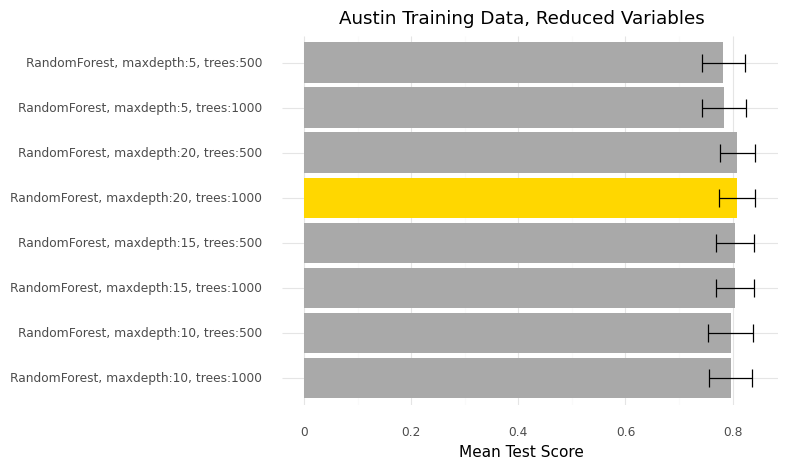

<ggplot: (8774294190132)>

In [198]:
(
ggplot(table, aes(x='model', y='mean_test_score',
                  fill='max')) + 
    geom_col() + 
    geom_errorbar(aes(ymin="low",ymax="high"),width=.4) + 
    scale_fill_manual(values=('darkgray','gold'), guide=None) + 
    coord_flip() + 
    labs(x='', y='Mean Test Score', title='Austin Training Data, Reduced Variables') + 
    theme_minimal()
)

### Plot & Evaluated Predicted Probabilities - Reduced

In [101]:
preds_r = rf_mod_r.predict_proba(train_Xr)[:,1]

In [102]:
preds_bin_r = preds_r.copy()

preds_bin_r = np.where(preds_bin_r >= .05, 1, preds_bin_r)
preds_bin_r = np.where(preds_bin_r < .05, 0, preds_bin_r)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     79729
           1       0.21      0.63      0.31      1499

    accuracy                           0.95     81228
   macro avg       0.60      0.79      0.64     81228
weighted avg       0.98      0.95      0.96     81228



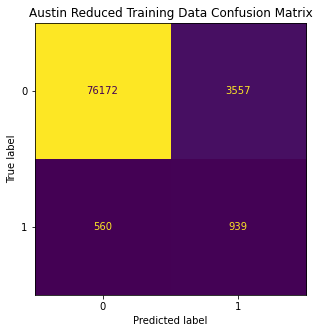

In [199]:
print(m.classification_report(train_yr, preds_bin_r))

m.ConfusionMatrixDisplay.from_predictions(train_yr, preds_bin_r, colorbar=False)
plt.rcParams["figure.figsize"] = (5, 5)
plt.title('Austin Reduced Training Data Confusion Matrix')
plt.show()

## Predicting Austin Test Data

In [186]:
# fit the default Austin model on the new data

m.roc_auc_score(test_y,rf_mod.predict_proba(test_X)[:,1])

0.7961639639798608

In [187]:
m.accuracy_score(test_y,rf_mod.predict(test_X))

0.9810909628097647

In [188]:
preds_t = rf_mod.predict_proba(test_X)[:,1]

In [189]:
preds_bin_t = preds_t.copy()

preds_bin_t = np.where(preds_bin_t >= .05, 1, preds_bin_t)
preds_bin_t = np.where(preds_bin_t < .05, 0, preds_bin_t)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     26565
           1       0.11      0.32      0.16       512

    accuracy                           0.94     27077
   macro avg       0.55      0.64      0.56     27077
weighted avg       0.97      0.94      0.95     27077



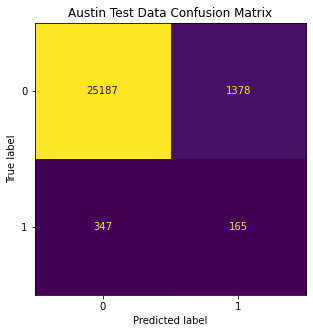

In [200]:
print(m.classification_report(test_y, preds_bin_t))

m.ConfusionMatrixDisplay.from_predictions(test_y, preds_bin_t, colorbar=False)
plt.rcParams["figure.figsize"] = (5, 5)
plt.title('Austin Test Data Confusion Matrix')
plt.show()

## Austin Test Data - PCA

In [175]:
# fit the default Austin model on the new data

m.roc_auc_score(test_yp,rf_mod_pca.predict_proba(test_Xp)[:,1])

0.8023144145256916

In [176]:
m.accuracy_score(test_yp,rf_mod_pca.predict(test_Xp))

0.9810170993832404

In [177]:
preds_tp = rf_mod_pca.predict_proba(test_Xp)[:,1]

In [178]:
preds_bin_tp = preds_tp.copy()

preds_bin_tp = np.where(preds_bin_tp >= .05, 1, preds_bin_tp)
preds_bin_tp = np.where(preds_bin_tp < .05, 0, preds_bin_tp)

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     26565
           1       0.11      0.39      0.17       512

    accuracy                           0.93     27077
   macro avg       0.55      0.66      0.57     27077
weighted avg       0.97      0.93      0.95     27077



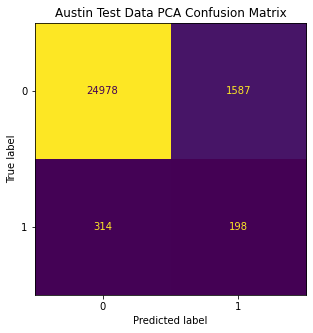

In [201]:
print(m.classification_report(test_yp, preds_bin_tp))

m.ConfusionMatrixDisplay.from_predictions(test_yp, preds_bin_tp, colorbar=False)
plt.rcParams["figure.figsize"] = (5, 5)
plt.title('Austin Test Data PCA Confusion Matrix')
plt.show()